# Large-Domain Animation

This Notebook generates large-domain prediction plots and animations.  It is principally designed for a CONUS-scale run prepared for AGU24.  It is assumed that predictions are already available.

The run in question involves ~100k points for ~20 years.  At daily resolution, this is a few tens of gigabytes of data, which is obviously unworkable.  Instead, we're just going to use (quite arbitrarily) 2021, which should be just a couple of gigabytes.  So the first thing we have to do is reorganize the data, incrementally.

Then the plot.  ~100k pour point temperatures is, if square and evenly distributed, about 300x300, which should be visible at high resolution, though it's going to look like more of a surface than a river network in a lot of places.  Hopefully the images will compress reasonably well.

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
outpath = "/scratch/dphilippus/pyproc/CONUS2021.csv"

# Reorganize Data

First things first: incrementally grab lat, lon, date, temperature for each river for 2021 only and put that in one big file.  While we're at it, we'll filter for near-continuous coverage, since things get a bit weird with gappy data.

In [15]:
import os
inpath = "/scratch/dphilippus/pyproc/CONUS12/"

In [103]:
inputs = os.listdir(inpath)
append = False
counter = 0
for inp in inputs:
    dat = pd.read_csv(inpath + inp, dtype={"id": "str"}, parse_dates=["date"])[["date", "lat", "lon", "temp.mod"]]
    dat = dat[(dat["date"] >= "2021-01-01") & (dat["date"] < "2022-01-01")]
    if len(dat) > 350:
        dat.to_csv(outpath, index=False, header=not append, mode='a' if append else 'w')
        append = True
    if counter % 100 == 0:
        print("|", end="")
    counter += 1

||||||||||||||

# Load Data and Make Individual Plots

In [104]:
data = pd.read_csv(outpath, parse_dates=["date"])
data = data[(data["temp.mod"] > -1) & (data["temp.mod"] < 40)]
data["date"] = data["date"].dt.normalize()
data

,date,lat,lon,temp.mod
0,2021-01-01,40.580555,-81.925437,2.009310
1,2021-01-02,40.580555,-81.925437,2.202661
2,2021-01-03,40.580555,-81.925437,2.330705
3,2021-01-04,40.580555,-81.925437,2.058024
4,2021-01-05,40.580555,-81.925437,1.532304
...,...,...,...,...
501140,2021-12-27,36.252768,-121.416060,11.207516
501141,2021-12-28,36.252768,-121.416060,11.118429
501142,2021-12-29,36.252768,-121.416060,11.027598
501143,2021-12-30,36.252768,-121.416060,11.092393


Text(0, 0.5, 'Latitude (deg)')

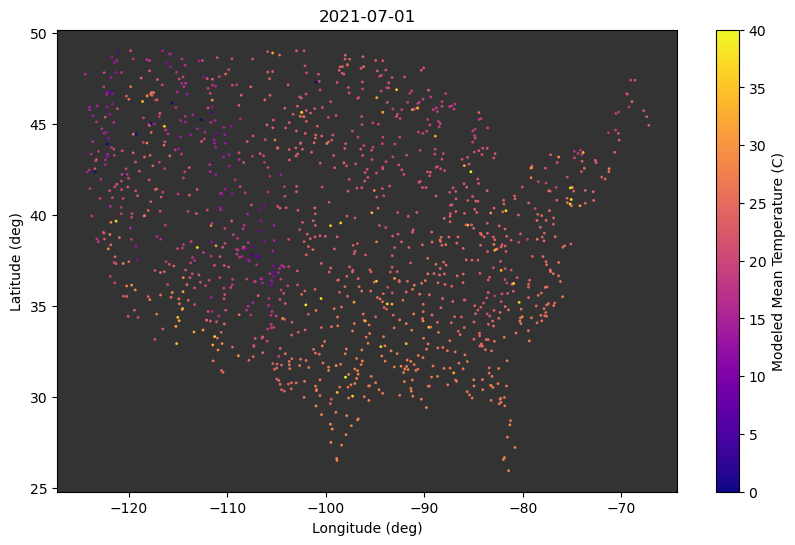

In [105]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(facecolor="#333")
jul1 = data[data["date"] == "2021-07-01"]
jul1.plot.scatter(x="lon", y="lat", c="temp.mod", title="2021-07-01", ax=ax, colormap="plasma", s=1, vmin=0, vmax=40)
cb = ax.collections[0].colorbar
cb.set_label("Modeled Mean Temperature (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
# _ = ax.set_title("2021-07-01")

# Animate It!

MovieWriter ffmpeg unavailable; using Pillow instead.


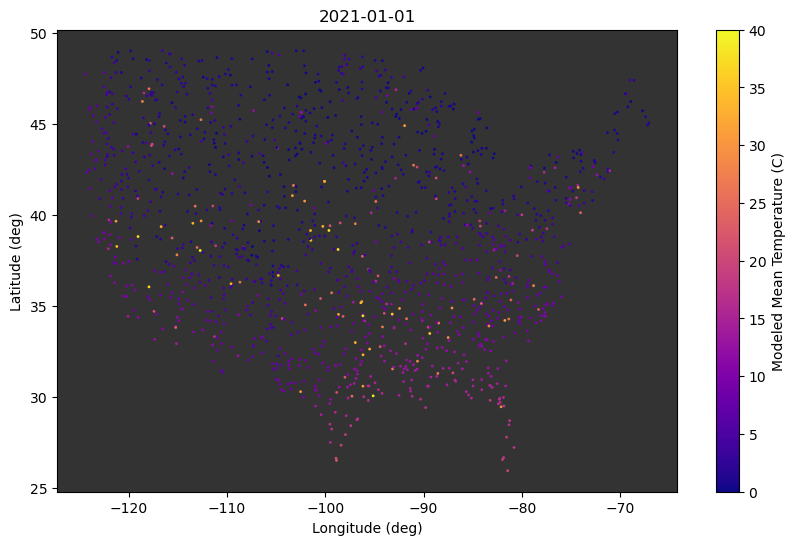

In [107]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(facecolor="#333")
dates = np.array(data["date"].unique(), dtype='datetime64[D]')
def animate(i):
    date = dates[i]
    fig.clear()
    ax = plt.axes(facecolor="#333")
    data[data["date"] == date].plot.scatter(x="lon", y="lat", c="temp.mod", title=str(date), ax=ax, colormap="plasma", s=1, vmin=0, vmax=40)
    ax.collections[0].colorbar.set_label("Modeled Mean Temperature (C)")
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")

a = anim.FuncAnimation(fig, animate, interval=150, frames=range(len(dates)))
a.save("conus2021.gif")